In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [4]:


# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


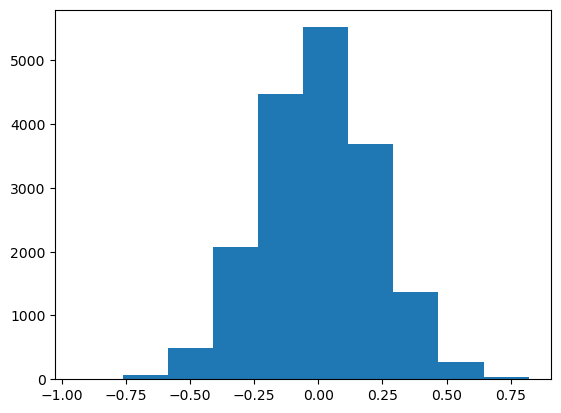

In [25]:
plt.hist(W1.view(-1).tolist())
plt.show()

In [8]:
g = torch.Generator().manual_seed(2147483647) 

emb_size = 20
n_hidden = 300

C = torch.randn((vocab_size, emb_size),             generator=g)
W1 = torch.randn((emb_size * block_size, n_hidden), generator=g) * (5/3) / (emb_size * block_size) ** 0.5
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running  = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

In [336]:
def plotter(C, ax ):
    # plt.figure(figsize=(8,8))
    ax.scatter(C[:,0].data, C[:,1].data, s=100)
    for i in range(C.shape[0]):
        ax.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    ax.set_title(f"{C.shape}")
    ax.grid('minor')


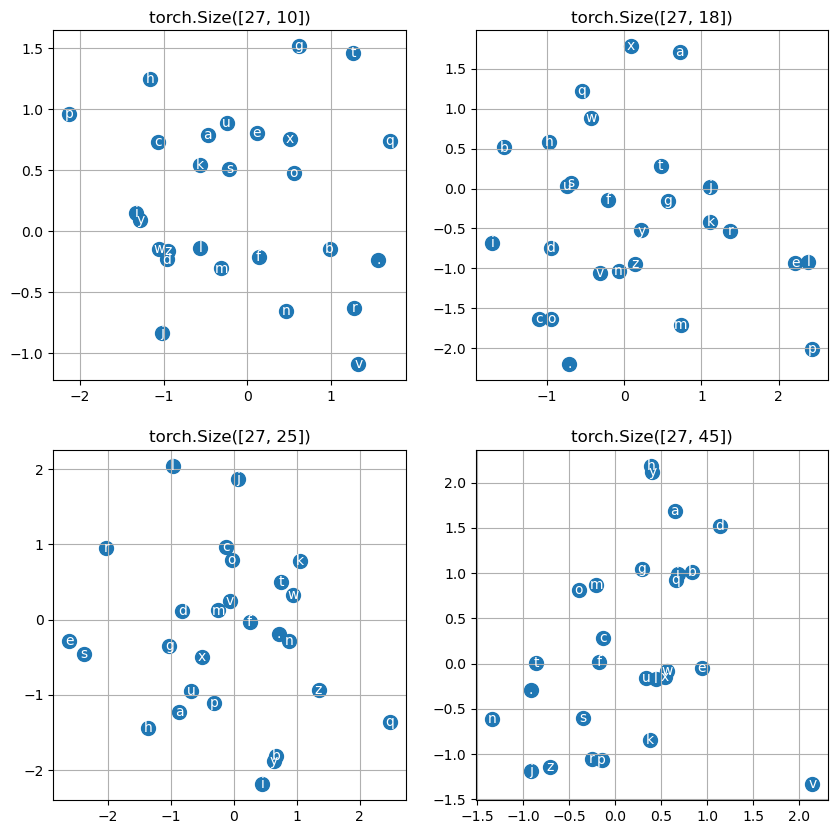

In [338]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) # Optional: set figure size
plotter(C, axs[0][0])
plotter(C1, axs[0][1])
plotter(C2, axs[1][0])
plotter(C3, axs[1][1])

plt.show()

In [266]:
sum(p.nelement() for p in parameters)

27567

In [8]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre 


In [7]:
def infoer(d, ds=False):
    print(d.shape)
    if ds == True:
        print(d) 
    print("")

In [284]:
hpreact

tensor([[-1.6212,  0.6502,  1.3701,  ..., -0.8380, -1.0960,  0.7596],
        [-0.6036,  0.3047,  0.4435,  ...,  0.7930,  0.4475,  0.8179],
        [-0.0531, -0.3543,  2.4690,  ...,  0.2322,  1.7759,  2.2557],
        ...,
        [ 2.6794, -1.6953,  0.6214,  ..., -0.2537, -0.4692,  0.3900],
        [ 2.5118,  1.2579, -1.2952,  ..., -0.0870,  1.6988,  0.2013],
        [ 0.7836,  0.1957,  2.1257,  ..., -2.5344,  3.0904, -1.5290]])

In [9]:
lri = []
lossi = []
stepi = []

    # |---- CONSTANTS ----|
batch_size = 64
steps = 30000


for i in range(steps):

    # |---- MINIBATCH CONSTRUCT ----|

    ix     = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # |---------- FORWARD ----------|
    
    emb     = C[Xb]             
    embcat  = emb.view(emb.shape[0], -1)
            # |---- HIDDEN LINEAR LAYER PRE ACTIVATION ----|
    hpreact = embcat @ W1 #+ b1 
                            # ^-------------------------------------------------------------------------------------+
        # |---- BATCH NORMALIZATION ----|

    bnmeani = hpreact.mean(0, keepdim=True) # <-+---- CENTERING ACTIVATION BATCH TO GAUSSIAN DISTRIBUTION
    bnstdi  = hpreact.std(0, keepdim=True)  # <-+
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # <----- SHIFTS THE BATCH
                # ^------ SCALES THE BATCH        
    
    with torch.no_grad(): # <----- NOT UPDATED DURING BACKPROP
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # <----+----- NEEDED FOR INFERENCE SO THAT WE
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # <-------+      DON'T HAVE TO REESTIMATE bnmeani,
                                                                              # bnmeanstdi

        # |------- NON-LINEARITY -------|
    
    h      = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss   = F.cross_entropy(logits, Yb)
    
    if i % 250 == 0 or i == steps - 1:    
        print(f"{i}/{steps}: {loss.item():.4f}")        


    # |---------- BACKWARD ---------|

    for p in parameters:
        p.grad = None
    loss.backward()

    # |---------- UPDATE ----------|

    lr     = 0.1 if i < 8000 else (0.05 if i < 16000 else 0.01)  
    for p in parameters:
        p.data += -lr * p.grad
    
    # |---------- STATS ----------|

    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print(loss.item())

0/30000: 3.2746
250/30000: 2.4516
500/30000: 2.3817
750/30000: 2.3160
1000/30000: 2.5171
1250/30000: 2.5353
1500/30000: 2.3942
1750/30000: 2.4628
2000/30000: 2.2910
2250/30000: 2.3483
2500/30000: 2.3341
2750/30000: 2.3172
3000/30000: 2.2828
3250/30000: 2.2311
3500/30000: 2.0626
3750/30000: 2.1098
4000/30000: 2.0282
4250/30000: 2.2995
4500/30000: 2.0178
4750/30000: 2.0403
5000/30000: 2.0449
5250/30000: 2.0630
5500/30000: 2.2261
5750/30000: 2.1841
6000/30000: 2.4064
6250/30000: 2.1509
6500/30000: 2.0213
6750/30000: 2.2228
7000/30000: 2.3150
7250/30000: 2.1775
7500/30000: 2.1826
7750/30000: 2.2115
8000/30000: 2.2669
8250/30000: 2.1827
8500/30000: 2.1135
8750/30000: 2.2640
9000/30000: 2.1396
9250/30000: 2.4095
9500/30000: 2.2299
9750/30000: 1.7403
10000/30000: 2.1295
10250/30000: 2.0588
10500/30000: 2.3391
10750/30000: 1.9870
11000/30000: 1.9505
11250/30000: 2.1766
11500/30000: 2.3137
11750/30000: 2.1003
12000/30000: 2.0807
12250/30000: 2.2390
12500/30000: 1.9567
12750/30000: 2.2306
13000/

<Figure size 1500x600 with 0 Axes>

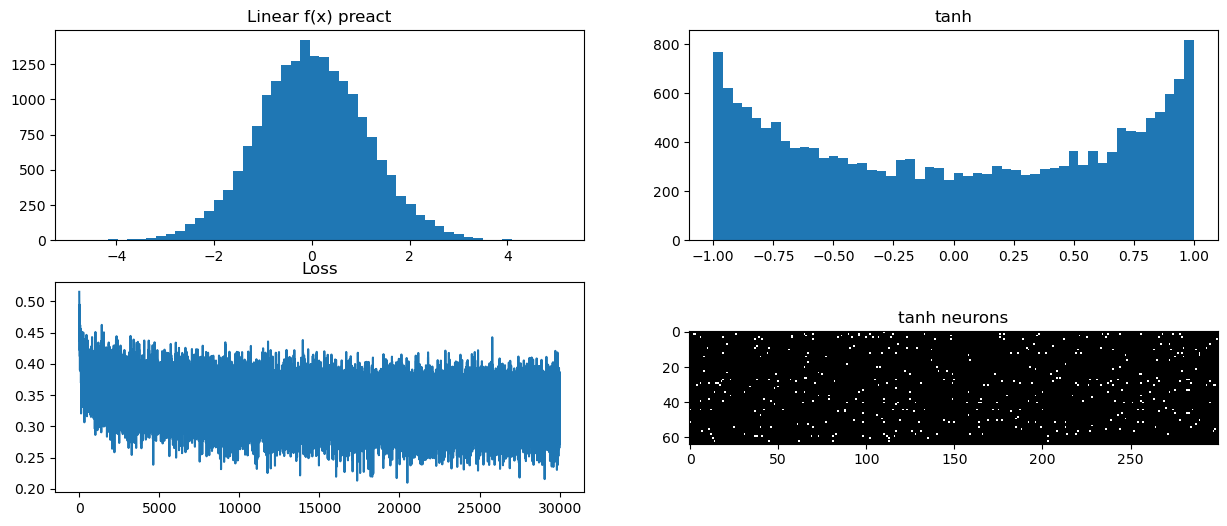

In [10]:
plt.figure(figsize=(15, 6))
fig, axs = plt.subplots(2, 2, figsize=(15, 6))

axs[0, 0].hist(hpreact.view(-1).tolist(), 50)
axs[0, 0].set_title("Linear f(x) preact")
axs[0, 1].hist(h.view(-1).tolist(), 50)
axs[0, 1].set_title("tanh")
axs[1, 0].plot(lossi)
axs[1, 0].set_title("Loss")
axs[1, 1].imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')
axs[1, 1].set_title("tanh neurons")
plt.show()



In [7]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [8]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[X]                 # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.167860984802246
val 2.1818761825561523
test 2.1833086013793945


In [55]:
layers[-1].

tensor([[-0.0342,  0.0814,  0.0538,  ...,  0.0364,  0.0058, -0.0440],
        [ 0.1137,  0.0615, -0.0230,  ..., -0.1474,  0.0221,  0.0488],
        [ 0.0088, -0.0237, -0.0420,  ..., -0.0929,  0.0926, -0.0558],
        ...,
        [-0.0501, -0.0067,  0.0297,  ..., -0.0333, -0.0190, -0.0282],
        [ 0.0830,  0.0576, -0.0498,  ...,  0.0080, -0.0255, -0.0017],
        [-0.0068,  0.0042, -0.0096,  ..., -0.1077,  0.0427,  0.0239]])

In [64]:


# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 20 # the dimensionality of the character embedding vectors
n_hidden = 150 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



104367


In [65]:


# same optimization as last time
max_steps = 30000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 500 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

    

      0/  30000: 3.3015
    500/  30000: 2.2190
   1000/  30000: 2.4125


layer 1 (      Tanh): mean -0.06, std 0.64, saturated: 5.09%
layer 3 (      Tanh): mean -0.01, std 0.54, saturated: 0.49%
layer 5 (      Tanh): mean +0.01, std 0.52, saturated: 0.08%
layer 7 (      Tanh): mean +0.01, std 0.52, saturated: 0.30%
layer 9 (      Tanh): mean -0.03, std 0.54, saturated: 0.17%


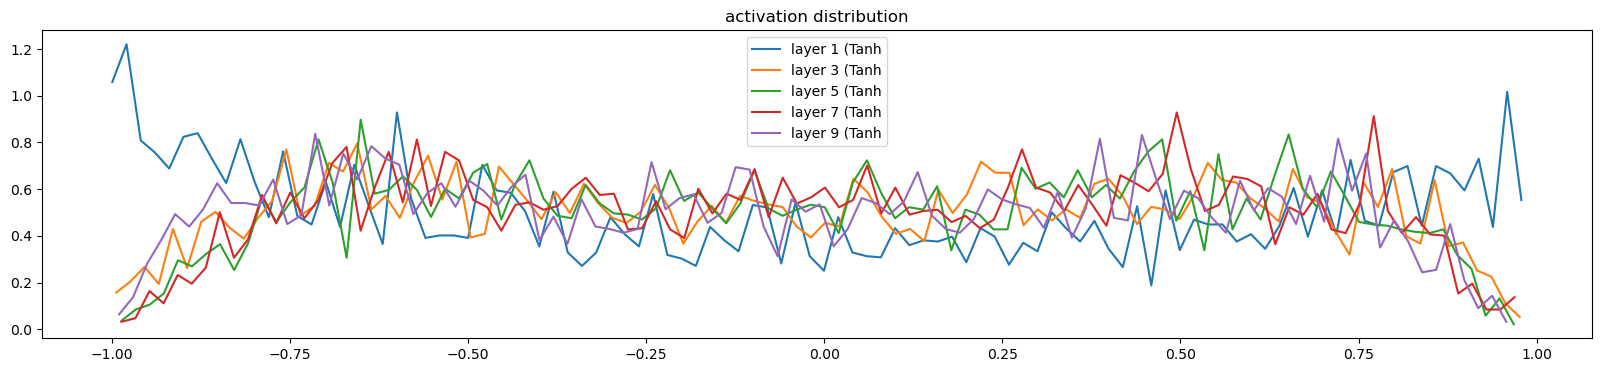

In [66]:


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()
